In [1]:
import pandas as pd
import os
import time

from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from LSTM.TR_preprocess import preprocess
from LSTM.LSTM_classifier import LSTMclf
from tools.tools import evaluate

#### Load training and test data sets

In [2]:
pos_train_path = os.path.join('Data', 'pos_train.csv')
pos_train = pd.read_csv(pos_train_path)

neg_train_path = os.path.join('Data', 'neg_train.csv')
neg_train = pd.read_csv(neg_train_path)

pos_test_path = os.path.join('Data', 'pos_test.csv')
pos_test = pd.read_csv(pos_test_path)

neg_test_path = os.path.join('Data', 'neg_test.csv')
neg_test = pd.read_csv(neg_test_path)

#### Preprocessing data

Reconstructs data into regularly intervaled time sequences (10 minut intervals)

In [3]:
print('Preprocessing training data...')
train_data, train_labels, max_times = preprocess(pos_train, neg_train)
input_shape = train_data.shape
print(f'Train data shape: {train_data.shape} train labels shape: {train_labels.shape}')

train_data = train_data.tolist()
train_labels = train_labels.tolist()

print('Preprocessing test data...')
test_data, test_labels, _ = preprocess(pos_test, neg_test, max_times=max_times)
print(f'Test data shape: {test_data.shape} test labels shape: {test_labels.shape}')

test_data = test_data.tolist()
test_labels = test_labels.tolist()

Preprocessing training data...


generate: 100%|██████████| 357/357 [00:11<00:00, 31.83it/s] 


Train data shape: (716, 1312, 5) train labels shape: (716,)
Preprocessing test data...


generate: 100%|██████████| 37/37 [00:00<00:00, 57.16it/s] 

Test data shape: (74, 1312, 5) test labels shape: (74,)


#### Instantiate LSTM model

In [4]:
clf = LSTMclf(input_shape)
clf.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 1312, 5)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 200)               164800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 165,001
Trainable params: 165,001
Non-trainable params: 0
_________________________________________________________________


#### Train different batch sizes with 5-fold cross validation

In [5]:
batch_sizes = [32, 64, 128, 256]
results = []
start_time = time.time()
for batch_size in batch_sizes:
    print(f'Cross validation with batch size {batch_size}.')
    metrics = clf.trainCV(train_data, train_labels, 5, batch_size, 10)
    metrics['batch_size'] = batch_size
    results.append(metrics)

    model_path = os.path.join('./LSTM/tr_results', f'LSTM{batch_size}.h5')
    clf.model.save(model_path)

elapsed_time = time.time() - start_time
results_df = pd.DataFrame(results, columns=['batch_size', 'accuracy', 'precision', 
                                            'recall', 'f1', 'auc'])
hr = int(elapsed_time // 3600)
elapsed_time %= 3600
min = int(elapsed_time // 60)
sec = elapsed_time % 60
print(f'Total time: {hr:02d}:{min:02d}:{sec:0.2f}')

result_path = os.path.join('./LSTM/tr_results', 'results.csv')
results_df.to_csv(result_path)
results_df


Cross validation with batch size 32.
Beginning training LSTM with 5-fold validation...
Epoch 1/10
18/18 [==============================] - 85s 5s/step - loss: 0.6456 - accuracy: 0.6510
Epoch 2/10
18/18 [==============================] - 86s 5s/step - loss: 0.5990 - accuracy: 0.7190
Epoch 3/10
18/18 [==============================] - 84s 5s/step - loss: 0.5742 - accuracy: 0.7260
Epoch 4/10
18/18 [==============================] - 82s 5s/step - loss: 0.6029 - accuracy: 0.6736
Epoch 5/10
18/18 [==============================] - 82s 5s/step - loss: 0.6420 - accuracy: 0.6719
Epoch 6/10
18/18 [==============================] - 82s 5s/step - loss: 0.6024 - accuracy: 0.7051
Epoch 7/10
18/18 [==============================] - 82s 5s/step - loss: 0.6188 - accuracy: 0.6789
Epoch 8/10
18/18 [==============================] - 87s 5s/step - loss: 0.5683 - accuracy: 0.7155
Epoch 9/10
18/18 [==============================] - 84s 5s/step - loss: 0.5108 - accuracy: 0.7417
Epoch 10/10
5/5 [==============

,batch_size,accuracy,precision,recall,f1,auc
0,32,0.507692,0.508951,0.554318,0.530667,0.507496
1,64,0.317483,0.319328,0.317549,0.318436,0.317482
2,128,0.593007,0.657407,0.395543,0.493913,0.593839
3,256,0.367832,0.334520,0.261838,0.293750,0.368279


#### Evaluate selected model

We will pick the best of the four trained above, and use it to predict on the test data. 

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        37
           1       0.81      0.78      0.79        37

    accuracy                           0.80        74
   macro avg       0.80      0.80      0.80        74
weighted avg       0.80      0.80      0.80        74



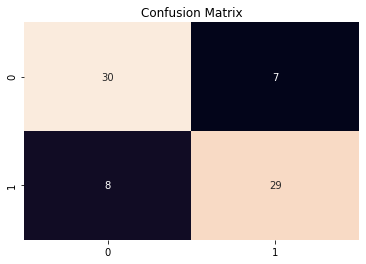

In [8]:
model_path = os.path.join('./LSTM/results2', 'LSTM128.h5')
clf = load_model(model_path, compile=False)

pred = clf.predict(test_data).reshape(-1)
pred = (pred > 0.5).astype(int)
metrics = evaluate(test_labels, pred)

print(classification_report(test_labels, pred))
cm = confusion_matrix(test_labels, pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix')
plt.show()